In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import scipy as sp
import scipy.io as sio

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import pandas as pd
import seaborn as sns
import string

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut

from sklearn.utils import resample

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [3]:
def plot_confusion_matrix(cm, std, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
        
    cm = cm.astype('float')
    std = std.astype('float')

    fig, ax = plt.subplots(figsize=(8,6), dpi=150)

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    fmt_std = '.3f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
            ax.text(j, i+0.15, '('+format(std[i, j], fmt_std)+')',
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [4]:
data = sio.loadmat("lssd_pca_118.mat")

names = [name[0][0] for name in data['names']]
names_df = pd.DataFrame([name.split('_') for name in names], columns=['Genus', 'Catalog_No', '1','2']).iloc[:,:2]
names_df['ID'] = names

hominoids = pd.read_csv('hominoid_procrustes_coordinates.csv')
hominoids = hominoids[hominoids['ID'].isin(names)]
new_names = hominoids[hominoids['ID'].isin(names)]['ID']
hominoids = hominoids.set_index('ID')

hominoid_landmarks = pd.read_csv('Cuboid_21L_coords.csv')
hominoid_landmarks = hominoid_landmarks[hominoid_landmarks['ID'].isin(new_names)]
hominoid_landmarks = hominoid_landmarks.set_index('ID')

auto3dgm = pd.read_csv('auto3dgm_procrustes_coordinates_12K_256.csv') #auto3dgm_procrustes_coordinates_12K_512
auto3dgm = auto3dgm[auto3dgm['ID'].isin(new_names)]
auto3dgm = auto3dgm.set_index('ID')

area_lssds = pd.concat([names_df, pd.DataFrame(data['area_based'][:,:4900], columns=['L' + str(j) for j in list(range(1,4901))])], axis=1)
area_lssds = area_lssds[area_lssds['ID'].isin(new_names)]
area_lssds = area_lssds.set_index('ID')

conf_lssds = pd.concat([names_df, pd.DataFrame(data['conf_based'][:,:4900], columns=['L' + str(j) for j in list(range(1,4901))])], axis=1)
conf_lssds = conf_lssds[conf_lssds['ID'].isin(new_names)]
conf_lssds = conf_lssds.set_index('ID')

auto3dgm_y = auto3dgm['Genus']
hominoid_y = hominoids['Genus']
area_lssds_y = area_lssds['Genus']
conf_lssds_y = conf_lssds['Genus']
hominoid_landmarks_y = hominoid_landmarks['Genus']

conf_area_lssds = pd.concat([conf_lssds,area_lssds], axis=1)
conf_area_lssds_y = area_lssds['Genus']

del conf_area_lssds['Genus']
del conf_area_lssds['Catalog_No']

del area_lssds['Genus']
del area_lssds['Catalog_No']
del conf_lssds['Genus']
del conf_lssds['Catalog_No']
del auto3dgm['Genus']
del hominoids['Genus']
del hominoid_landmarks['Genus']

In [5]:
scaler_area = StandardScaler()
scaler_conf = StandardScaler()
scaler_auto = StandardScaler()
scaler_coords = StandardScaler()
scaler_coords2 = StandardScaler()

scalar_conf_area = StandardScaler()

skfoldcv = StratifiedKFold(n_splits=11)


X_conf_area_scaled = scalar_conf_area.fit_transform(np.array(conf_area_lssds))


X_area_scaled = scaler_area.fit_transform(np.array(area_lssds))
X_conf_scaled = scaler_conf.fit_transform(np.array(conf_lssds))
X_auto_scaled = scaler_area.fit_transform(np.array(auto3dgm))
X_coords_scaled = scaler_coords.fit_transform(np.array(hominoids))
X_coords2_scaled = scaler_coords2.fit_transform(np.array(hominoid_landmarks))

In [ ]:
pca_coords = PCA()
pca_coords.fit(X_coords_scaled)

X_coords = pca_coords.transform(X_coords_scaled)
X_coords_pcs = pd.DataFrame(X_coords[:, :27],
                          columns=['PC' + str(j) for j in list(range(1,27+1))],
                         index=hominoids.index)
X_coords_pcs['Genus'] = hominoid_y
X_coords_pcs.Genus = pd.Categorical(X_coords_pcs.Genus)
X_coords_pcs['Group'] = X_coords_pcs.Genus.cat.codes
y_coords_labels = list(X_coords_pcs['Genus'])
y_coords = np.array(X_coords_pcs['Group'])

In [ ]:
coords_scores = []
coords_cnf_matrices = []
coords_pred = []
coords_y = []

for i in range(1000):
    new_X_coords, new_y_coords = resample(X_coords[:, :27],y_coords,
                                          n_samples=102, replace=True,
                                          stratify=y_coords_labels)
    coords_y.append(new_y_coords)
    model_coords = GaussianNB()
    scores = cross_val_score(model_coords, new_X_coords, new_y_coords,
                             scoring='accuracy', cv=skfoldcv, n_jobs=-1)
    coords_scores.append(scores)
    y_pred = cross_val_predict(model_coords, new_X_coords, new_y_coords, cv=skfoldcv, n_jobs=-1)
    coords_pred.append(y_pred)
    cnf = confusion_matrix(new_y_coords, y_pred, labels=[0, 1, 2, 3, 4])
    cnf = cnf.astype('float') / cnf.sum(axis=1)[:, np.newaxis]
    coords_cnf_matrices.append(cnf)
print(classification_report(np.concatenate(coords_y,axis=0),
                            np.concatenate(coords_pred,axis=0),
                            target_names=['Gorilla', 'Homo', 'Hylobates', 'Pan', 'Pongo']))

In [ ]:
new_cnf = np.array(coords_cnf_matrices).mean(axis=0)
new_cnf_std = np.array(coords_cnf_matrices).std(axis=0)
plot_confusion_matrix(new_cnf, new_cnf_std, ['Gorilla', 'Homo', 'Hylobates', 'Pan', 'Pongo'],
                      title='Procrustes Coordinates')

In [ ]:
pca_coords2 = PCA()
pca_coords2.fit(X_coords2_scaled)
X_coords2 = pca_coords2.transform(X_coords2_scaled)
# sum(pca_coords2.explained_variance_[:27])/sum(pca_coords2.explained_variance_)

X_coords2_pcs = pd.DataFrame(X_coords2[:, :27],
                          columns=['PC' + str(j) for j in list(range(1,27+1))],
                         index=hominoid_landmarks.index)
X_coords2_pcs['Genus'] = hominoid_landmarks_y
X_coords2_pcs.Genus = pd.Categorical(X_coords2_pcs.Genus)
X_coords2_pcs['Group'] = X_coords2_pcs.Genus.cat.codes
y_coords2_labels = list(X_coords2_pcs['Genus'])
y_coords2 = np.array(X_coords2_pcs['Group'])

In [ ]:
coords2_scores = []
coords2_cnf_matrices = []
coords2_pred = []
coords2_y = []

for i in range(1000):
    new_X_coords2, new_y_coords2 = resample(X_coords2[:, :27],y_coords2,
                                          n_samples=102, replace=True,
                                          stratify=y_coords2_labels)
    coords2_y.append(new_y_coords2)
    model_coords2 = GaussianNB()
    scores = cross_val_score(model_coords2, new_X_coords2, new_y_coords2,
                             scoring='accuracy', cv=skfoldcv, n_jobs=-1)
    coords2_scores.append(scores)
    y_pred = cross_val_predict(model_coords2, new_X_coords2, new_y_coords2, cv=skfoldcv, n_jobs=-1)
    coords2_pred.append(y_pred)
    cnf = confusion_matrix(new_y_coords2, y_pred, labels=[0, 1, 2, 3, 4])
    cnf = cnf.astype('float') / cnf.sum(axis=1)[:, np.newaxis]
    coords2_cnf_matrices.append(cnf)
print(classification_report(np.concatenate(coords2_y,axis=0),
                            np.concatenate(coords2_pred,axis=0),
                            target_names=['Gorilla', 'Homo', 'Hylobates', 'Pan', 'Pongo']))

In [ ]:
new_cnf = np.array(coords2_cnf_matrices).mean(axis=0)
new_cnf_std = np.array(coords2_cnf_matrices).std(axis=0)
plot_confusion_matrix(new_cnf, new_cnf_std, ['Gorilla', 'Homo', 'Hylobates', 'Pan', 'Pongo'],
                      title='(A) 21 Homologous Points')

In [6]:
pca_auto = PCA()
pca_auto.fit(X_auto_scaled)
X_auto = pca_auto.transform(X_auto_scaled)
X_auto_pcs = pd.DataFrame(X_auto[:, :54],
                          columns=['PC' + str(j) for j in list(range(1,54+1))],
                         index=auto3dgm.index)
X_auto_pcs['Genus'] = auto3dgm_y
X_auto_pcs.Genus = pd.Categorical(X_auto_pcs.Genus)
X_auto_pcs['Group'] = X_auto_pcs.Genus.cat.codes
y_auto_labels = list(X_auto_pcs['Genus'])
y_auto = np.array(X_auto_pcs['Group'])

In [7]:
auto_scores = []
auto_cnf_matrices = []
auto_pred = []
auto_y = []
for i in range(1000):
    new_X_auto, new_y_auto = resample(X_auto[:, :54], y_auto, n_samples=102, replace=True, stratify=y_auto_labels)    
    auto_y.append(new_y_auto)
    
    model_auto = GaussianNB()
    scores = cross_val_score(model_auto, new_X_auto, new_y_auto,
                             scoring='accuracy', cv=skfoldcv, n_jobs=-1)
    auto_scores.append(scores)
    y_pred = cross_val_predict(model_auto, new_X_auto, new_y_auto, cv=skfoldcv, n_jobs=-1)
    auto_pred.append(y_pred)
    
    cnf = confusion_matrix(new_y_auto, y_pred, labels=[0, 1, 2, 3, 4])
    cnf = cnf.astype('float') / cnf.sum(axis=1)[:, np.newaxis]
    auto_cnf_matrices.append(cnf)
print(classification_report(np.concatenate(auto_y,axis=0),
                            np.concatenate(auto_pred,axis=0),
                            target_names=['Gorilla', 'Homo', 'Hylobates', 'Pan', 'Pongo']))

              precision    recall  f1-score   support

     Gorilla       0.95      0.86      0.90     11000
        Homo       0.98      1.00      0.99     34000
   Hylobates       0.97      0.91      0.94     18000
         Pan       0.94      0.95      0.94     20000
       Pongo       0.91      0.96      0.93     19000

    accuracy                           0.95    102000
   macro avg       0.95      0.94      0.94    102000
weighted avg       0.95      0.95      0.95    102000



<AxesSubplot:title={'center':'Auto3DGM Pseudo-Landmarks'}, xlabel='Predicted label', ylabel='True label'>

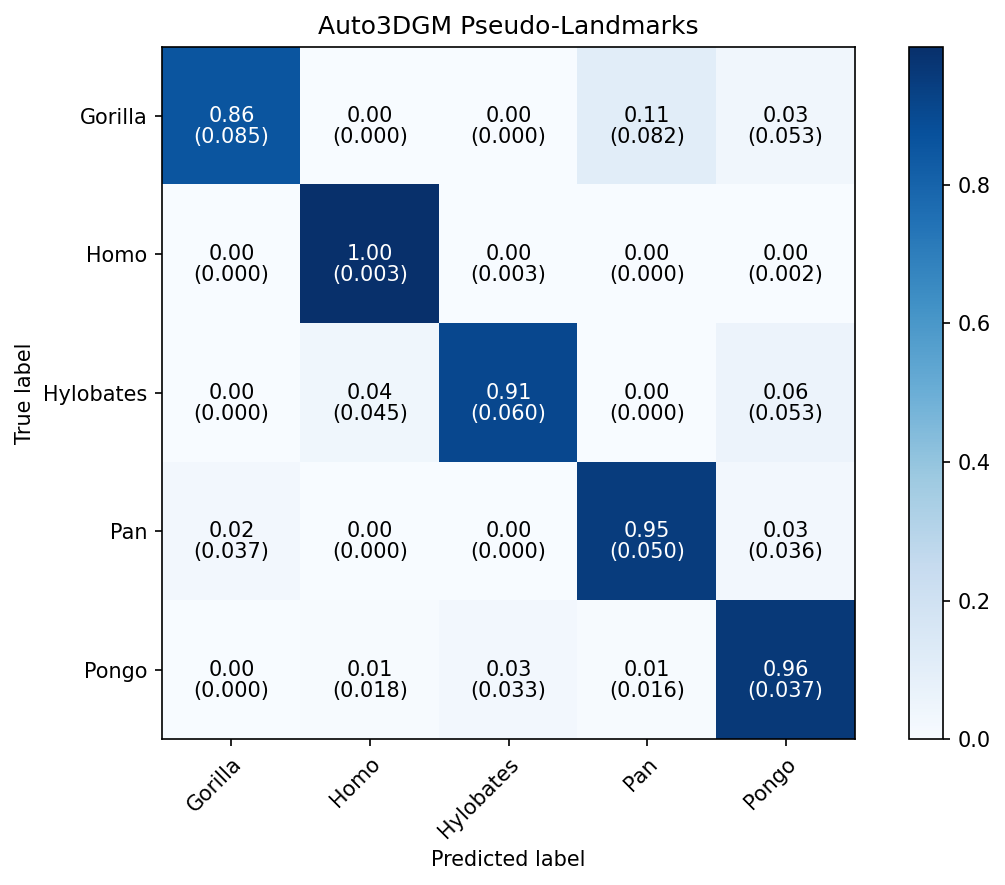

In [8]:
new_auto_cnf = np.array(auto_cnf_matrices).mean(axis=0)
new_auto_cnf_std = np.array(auto_cnf_matrices).std(axis=0)
plot_confusion_matrix(new_auto_cnf, new_auto_cnf_std,
                      ['Gorilla', 'Homo', 'Hylobates', 'Pan', 'Pongo'],
                      title='Auto3DGM Pseudo-Landmarks')

In [ ]:
pca_area = PCA()
pca_area.fit(X_area_scaled)
X_area = pca_area.transform(X_area_scaled)
X_area_pcs = pd.DataFrame(X_area[:,:60],
                          columns=['PC' + str(j) for j in list(range(1,60+1))],
                         index=area_lssds.index)
X_area_pcs['Genus'] = area_lssds_y
X_area_pcs.Genus = pd.Categorical(X_area_pcs.Genus)
X_area_pcs['Group'] = X_area_pcs.Genus.cat.codes
y_area_labels = list(X_area_pcs['Genus'])
y_area = np.array(X_area_pcs['Group'])

In [ ]:
area_scores = []
area_cnf_matrices = []
area_pred = []
area_y = []

for i in range(1000):
    new_X_area, new_y_area = resample(X_area[:,:60], y_area, n_samples=102, replace=True, stratify=y_area_labels)    
    area_y.append(new_y_area)
    model_area = GaussianNB()
    scores = cross_val_score(model_area, new_X_area, new_y_area,
                             scoring='accuracy', cv=skfoldcv, n_jobs=-1)
    area_scores.append(scores)
    y_pred = cross_val_predict(model_area, new_X_area, new_y_area, cv=skfoldcv, n_jobs=-1)
    area_pred.append(y_pred)
    cnf = confusion_matrix(new_y_area, y_pred, labels=[0, 1, 2, 3, 4])
    cnf = cnf.astype('float') / cnf.sum(axis=1)[:, np.newaxis]
    area_cnf_matrices.append(cnf)
    
print(classification_report(np.concatenate(area_y,axis=0),
                            np.concatenate(area_pred,axis=0),
                            target_names=['Gorilla', 'Homo', 'Hylobates', 'Pan', 'Pongo']))

In [ ]:
new_area_cnf = np.array(area_cnf_matrices).mean(axis=0)
new_area_cnf_std = np.array(area_cnf_matrices).std(axis=0)
plot_confusion_matrix(new_area_cnf, new_area_cnf_std,
                      ['Gorilla', 'Homo', 'Hylobates', 'Pan', 'Pongo'],
                      title='Area Latent Shape Space Differences')

In [ ]:
pca_conf_area = PCA()
pca_conf_area.fit(X_conf_area_scaled)
X_conf_area = pca_conf_area.transform(X_conf_area_scaled)
# sum(pca_conf_area.explained_variance_[:64])/sum(pca_conf_area.explained_variance_)
X_conf_area_pcs = pd.DataFrame(X_conf_area[:,:64],
                          columns=['PC' + str(j) for j in list(range(1,64+1))],
                         index=conf_area_lssds.index)
X_conf_area_pcs['Genus'] = conf_area_lssds_y
X_conf_area_pcs.Genus = pd.Categorical(X_conf_area_pcs.Genus)
X_conf_area_pcs['Group'] = X_conf_area_pcs.Genus.cat.codes
y_conf_area_labels = list(X_conf_area_pcs['Genus'])
y_conf_area = np.array(X_conf_area_pcs['Group'])

In [ ]:
conf_area_scores = []
conf_area_cnf_matrices = []
conf_area_pred = []
conf_area_y = []

for i in range(1000):
    new_X_conf_area, new_y_conf_area = resample(X_conf_area[:,:64], y_conf_area, n_samples=102, replace=True, stratify=y_conf_area_labels) #X_conf_area_scaled
    conf_area_y.append(new_y_conf_area)
    model_conf_area = GaussianNB()
    scores = cross_val_score(model_conf_area, new_X_conf_area, new_y_conf_area,
                             scoring='accuracy', cv=skfoldcv, n_jobs=-1)
    conf_area_scores.append(scores)
    y_pred = cross_val_predict(model_conf_area, new_X_conf_area, new_y_conf_area, cv=skfoldcv, n_jobs=-1)
    conf_area_pred.append(y_pred)
    cnf = confusion_matrix(new_y_conf_area, y_pred, labels=[0, 1, 2, 3, 4])
    cnf = cnf.astype('float') / cnf.sum(axis=1)[:, np.newaxis]
    conf_area_cnf_matrices.append(cnf)
    
print(classification_report(np.concatenate(conf_area_y,axis=0),
                            np.concatenate(conf_area_pred,axis=0),
                            target_names=['Gorilla', 'Homo', 'Hylobates', 'Pan', 'Pongo']))

In [ ]:
new_conf_area_cnf = np.array(conf_area_cnf_matrices).mean(axis=0)
new_conf_area_cnf_std = np.array(conf_area_cnf_matrices).std(axis=0)
plot_confusion_matrix(new_conf_area_cnf, new_conf_area_cnf_std,
                      ['Gorilla', 'Homo', 'Hylobates', 'Pan', 'Pongo'],
                      title='Conformal and Area Latent Shape Space Differences')

In [ ]:
conf_area = PCA()
conf_area.fit(X_conf_scaled)
X_conf = conf_area.transform(X_conf_scaled)
X_conf_pcs = pd.DataFrame(X_conf[:, :59],
                          columns=['PC' + str(j) for j in list(range(1,59+1))],
                         index=conf_lssds.index)
X_conf_pcs['Genus'] = conf_lssds_y
X_conf_pcs.Genus = pd.Categorical(X_conf_pcs.Genus)
X_conf_pcs['Group'] = X_conf_pcs.Genus.cat.codes
y_conf_labels = list(X_conf_pcs['Genus'])
y_conf = np.array(X_conf_pcs['Group'])

In [ ]:
conf_scores = []
conf_cnf_matrices = []
conf_pred = []
conf_y = []
for i in range(1000):
    new_X_conf, new_y_conf = resample(X_conf[:, :59],y_conf,
                                          n_samples=102, replace=True,
                                          stratify=y_conf_labels)
    conf_y.append(new_y_conf)
    model_conf = GaussianNB()
    scores = cross_val_score(model_conf, new_X_conf, new_y_conf,
                             scoring='accuracy', cv=skfoldcv, n_jobs=-1)
    conf_scores.append(scores)
    y_pred = cross_val_predict(model_conf, new_X_conf, new_y_conf, cv=skfoldcv, n_jobs=-1,)
    conf_pred.append(y_pred)
    
    cnf = confusion_matrix(new_y_conf, y_pred, labels=[0, 1, 2, 3, 4])
    cnf = cnf.astype('float') / cnf.sum(axis=1)[:, np.newaxis]
    conf_cnf_matrices.append(cnf)
print(classification_report(np.concatenate(conf_y,axis=0),
                            np.concatenate(conf_pred,axis=0),
                            target_names=['Gorilla', 'Homo', 'Hylobates', 'Pan', 'Pongo']))

In [ ]:
new_conf_cnf = np.array(conf_cnf_matrices).mean(axis=0)
new_conf_cnf_std = np.array(conf_cnf_matrices).std(axis=0)
plot_confusion_matrix(new_conf_cnf, new_conf_cnf_std,
                      ['Gorilla', 'Homo', 'Hylobates', 'Pan', 'Pongo'],
                      title='Conformal Latent Shape Space Differences')

In [ ]:
(np.mean(coords_scores), np.std(coords_scores)),\
(np.mean(coords2_scores), np.std(coords2_scores)),\
(np.mean(auto_scores), np.std(auto_scores)),\
(np.mean(conf_scores), np.std(conf_scores)),\
(np.mean(area_scores), np.std(area_scores)),\
(np.mean(conf_area_scores), np.std(conf_area_scores))

In [9]:
(np.mean(auto_scores), np.std(auto_scores))

(0.951528282828283, 0.06936200308300333)